In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import os, sys
import time
import math
from PIL import Image
from skimage import io, transform
import cv2 as cv
from tqdm import tqdm
import shutil
import imutils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.dataset import Dataset # For custom datasets
import torchvision.utils as vutils
import torchvision
from torchvision import datasets, transforms,models 

%load_ext autoreload
%autoreload 2

In [2]:
path = 'C:/Users/done-/Desktop/squares_image_colorization'
len(os.listdir(path))

4728

#### Remove mp4 data

In [3]:
# count = 0
# for name_file in os.listdir(path):
#     if name_file.endswith('.mp4'):
#         os.remove(path+'/'+name_file)
#         count += 1
# print('{} file mp4 deleted!'.format(count))

23 file mp4 deleted!


### Create train and validation sets

In [3]:
np.random.seed(456)  #Set seed to maintain the same sampling
valid_files = list(np.random.choice(os.listdir(path), 100))
valid_files_set = set(valid_files)
train_files = []
[train_files.append(file) for file in os.listdir(path) if file not in valid_files_set]
print('Training: {} samples\tValidation: {} samples'.format(len(train_files), len(valid_files)))

Training: 4628 samples	Validation: 100 samples


### Data Loader. It performs data augumentation on images (rotated, horizontally flipped and a little bit distorted) to increase the number of samples observed by the model for the training. It also converts images in B/W. 

In [4]:
class load_data(Dataset):
    def __init__(self, root_dir, files_names, transform=None, transform_gray=None):
        
        self.root_dir = root_dir 
        self.files = files_names
        self.transform = transform
        self.transform_gray = transform_gray

    def __len__(self):
        
        return len(self.files)

    def __getitem__(self, idx):
        
        nameimg = self.files[idx]
        img = io.imread(self.root_dir + '/' + nameimg)        
        sample = {'image': img}

        if self.transform:
            image_t = self.transform(sample["image"])
            if self.transform_gray:
                image_gray = self.transform_gray(image_t)
                sample = {'image': image_t, 'image_gray' : image_gray}
            else:
                sample = {'image': image_t}

        return sample

In [6]:
transf = transforms.Compose([transforms.ToPILImage(),
                             transforms.RandomApply(
                             [transforms.RandomHorizontalFlip(p=1),
                             transforms.RandomRotation(5),
                            #  transforms.RandomPerspective(distortion_scale=0.15, p=1)
                             ], p=0.5),
                             transforms.Resize(128),
                             transforms.CenterCrop(128),
                             transforms.ToTensor(),
#                              transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])   #Take [0,1] interval
                            ])

In [7]:
gray_transf = transforms.Compose([
#                           transforms.Normalize([ 0,0,0],[ 1/0.5, 1/0.5, 1/0.5 ]), # Unnormalize
#                           transforms.Normalize([-0.5,-0.5,-0.5 ],[ 1., 1., 1. ]), # Unnormalize
                          transforms.ToPILImage(),   # Convert to PIL to edit
                          transforms.Grayscale(num_output_channels=1),
                          transforms.ToTensor(),    # Return to tensor format
#                           transforms.Normalize([0.5], [0.5])
                                 ])

In [8]:
transf_val = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(128),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor(),
#                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                ])

In [9]:
train_loader = torch.utils.data.DataLoader(load_data(path, train_files, 
                                                     transform=transf,
                                                     transform_gray=gray_transf),
                                            batch_size=16)

In [10]:
len(train_loader)

290

In [11]:
valid_loader = torch.utils.data.DataLoader(load_data(path, valid_files, 
                                                     transform=transf_val,
                                                     transform_gray=gray_transf), 
                                           batch_size=16)

In [12]:
len(valid_loader)

7

### Showing some examples

In [13]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


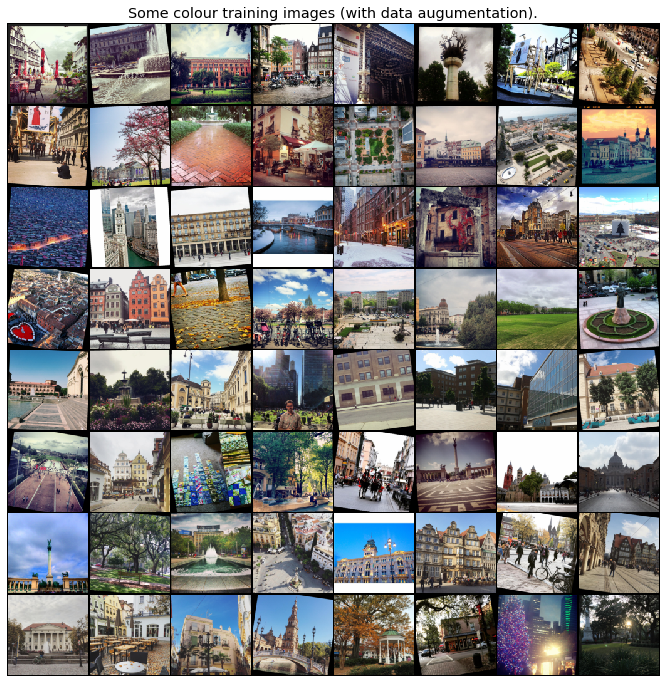

In [14]:
some_train_img = next(iter(train_loader))
plt.figure(figsize=(12,12))
plt.title('Some colour training images (with data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_train_img['image'].to(device)[:64], 
                                         padding=2, normalize=False).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

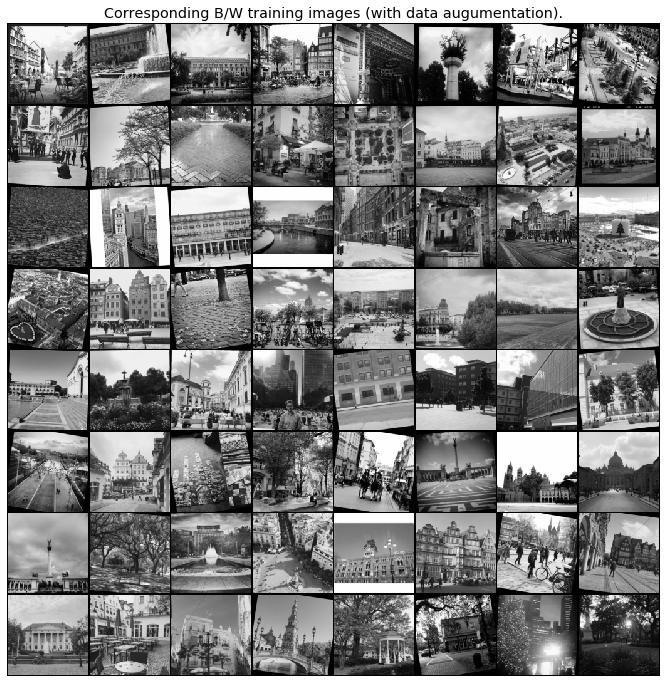

In [15]:
plt.figure(figsize=(12,12))
plt.title('Corresponding B/W training images (with data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_train_img['image_gray'].to(device)[:64], 
                                         padding=2, normalize=False).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [16]:
some_train_img = None #Free memory

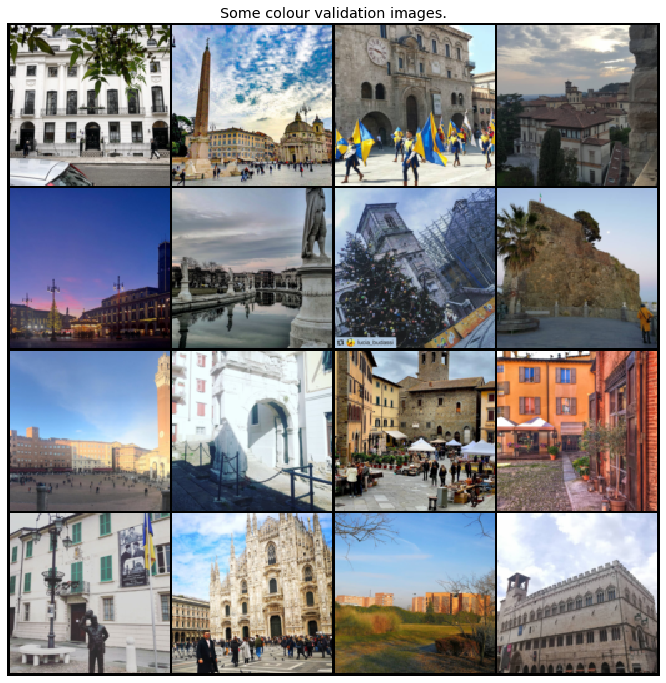

In [17]:
some_val_img = next(iter(valid_loader))
plt.figure(figsize=(12,12))
plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_val_img['image'].to(device)[:16], nrow=4,
                                         padding=2, normalize=False).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

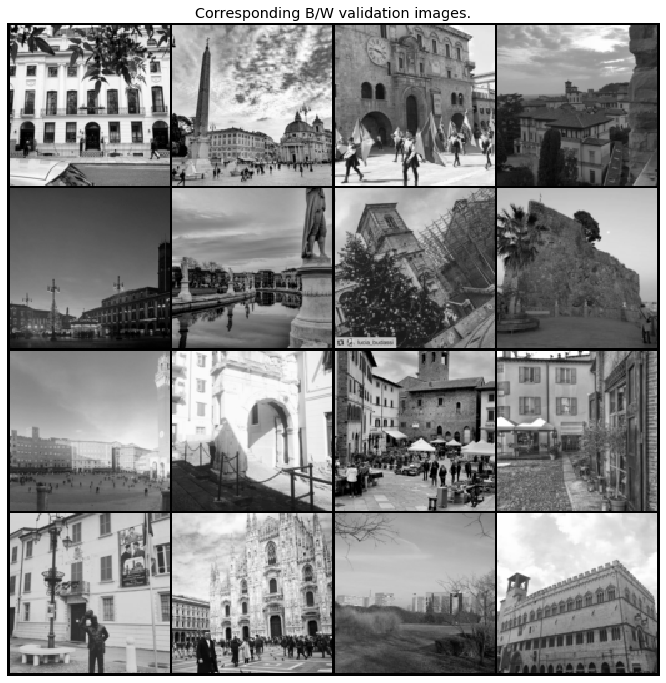

In [18]:
plt.figure(figsize=(12,12))
plt.title('Corresponding B/W validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_val_img['image_gray'].to(device)[:16], nrow=4,
                                         padding=2, normalize=False).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

In [19]:
some_val_img = None

### Here, it is given an examples about how the dataloader gray converter works.

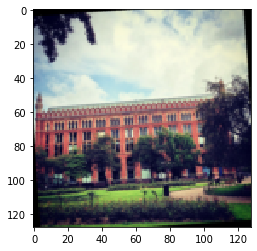

In [13]:
im = next(iter(train_loader))['image'][2]
im_np = im.numpy().transpose((1, 2, 0))
# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.5, 0.5, 0.5])
# im_np = std * im_np + mean
# inp = np.clip(inp, 0, 1)
plt.imshow(im_np)

In [14]:
gray_convert = transforms.Compose([
#                           transforms.Normalize([ 0,0,0],[ 1/0.5, 1/0.5, 1/0.5 ]), # Unnormalize
#                           transforms.Normalize([-0.5,-0.5,-0.5 ],[ 1., 1., 1. ]), # Unnormalize
                          transforms.ToPILImage(),   # Convert to PIL to edit
                          transforms.Grayscale(num_output_channels=1),
                          transforms.ToTensor(),    # Return to tensor format
#                           transforms.Normalize([0.5], [0.5])
                                  ])

In [15]:
im.shape

torch.Size([3, 128, 128])

In [16]:
print(im.min(), im.max())

tensor(0.) tensor(0.9922)


In [17]:
im2 = gray_convert(im)

In [18]:
# #Reput im2 in [0,1] interval
# im2 = im2*0.5
# im2 = im2+0.5
# im2

In [19]:
im2.shape

torch.Size([1, 128, 128])

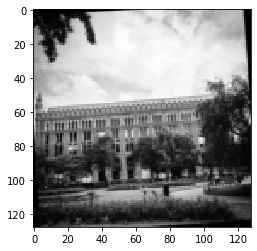

In [20]:
#Let's see if the tensor corresponds to the original image..
im2 = im2.numpy().reshape(128,128)
# mean = np.array([0.5])
# std = np.array([0.5])
# im2 = std * im2 + mean
plt.imshow(im2, cmap='gray')

In [21]:
print(im2.min(), im2.max())

0.0 0.9764706


#### Okkkk! è perfetto!

### Define AutoEncoder

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #Encoding layers
        self.conv1 = nn.Conv2d(1, 16, (3,3), stride=1, padding=1)  #out 16x128x128
        self.conv2 = nn.Conv2d(16, 32, (5,5), stride=1, padding=0) #out 32x124x124
        self.conv3 = nn.Conv2d(32, 64, (4,4), stride=2, padding=1) #out 64x62x62
        self.conv4 = nn.Conv2d(64, 128, (2,2), stride=2, padding=1) #out 128x32x32
        self.conv5 = nn.Conv2d(128, 512, (4,4), stride=2, padding=1) #out 512x16x16
        self.conv6 = nn.Conv2d(512, 1024, (4,4), stride=2, padding=1) #out 1024x8x8
        self.linear_enc = nn.Linear(1024*8*8, 512)
        
        #Decoding layers
        self.linear_dec = nn.Linear(512, 1024*8*8)
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), stride=2, padding=1) #512x16x16
        self.deconv2 = nn.ConvTranspose2d(512, 128, (4,4), stride=2, padding=1)  #128x32x32
        self.deconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride=2, padding=1)   #64x62x62
        self.deconv4 = nn.ConvTranspose2d(64, 32, (4,4), stride=2, padding=1)    #32x124x124
        self.deconv5 = nn.ConvTranspose2d(32, 16, (5,5), stride=1, padding=0)    #16x128x128
        self.deconv6 = nn.ConvTranspose2d(16, 3, (3,3), stride=1, padding=1)     #3x128x128

        #batch norms
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.bn1d_1 = nn.BatchNorm1d(512)
        self.bn1d_2 = nn.BatchNorm1d(1024*8*8)
        
    def Encoder(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.view(x.size()[0], 1024*8*8)
        z = F.relu(self.bn1d_1(self.linear_enc(x)))
        return z
    
    def Decoder(self, z):
        x = F.relu(self.bn1d_2(self.linear_dec(z)))
        x = x.view(x.size()[0], 1024, 8, 8)
        x = F.relu(self.bn5(self.deconv1(x)))
        x = F.relu(self.bn4(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn2(self.deconv4(x)))
        x = F.relu(self.bn1(self.deconv5(x)))
        out = F.sigmoid(self.deconv6(x))
        return out

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

In [21]:
autoencoder = AutoEncoder()
autoencoder.to(device)
summary(autoencoder, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
            Conv2d-3         [-1, 32, 124, 124]          12,832
       BatchNorm2d-4         [-1, 32, 124, 124]              64
            Conv2d-5           [-1, 64, 62, 62]          32,832
       BatchNorm2d-6           [-1, 64, 62, 62]             128
            Conv2d-7          [-1, 128, 32, 32]          32,896
       BatchNorm2d-8          [-1, 128, 32, 32]             256
            Conv2d-9          [-1, 512, 16, 16]       1,049,088
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
           Conv2d-11           [-1, 1024, 8, 8]       8,389,632
      BatchNorm2d-12           [-1, 1024, 8, 8]           2,048
           Linear-13                  [-1, 512]      33,554,944
      BatchNorm1d-14                  [

### Training Loop

In [15]:
def train_model(model, num_epochs=5, scheduler=None):
    since = time.time()

    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10e20
    
    LOGGER_TRAIN_LOSS = {}
    LOGGER_VALID_LOSS = {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 40)

        # Each epoch has a training and a validation phase so..
        for phase in ['training', 'validation']:
            if phase == 'training':
                if scheduler is not None:
                    scheduler.step()
                    if (epoch+1) % exp_lr_scheduler.step_size == 0:
                        print('Learning Rate Scheduler divides lr by a gamma of {:.1f}.\n'.format(
                              exp_lr_scheduler.gamma))
                        
                model.train()
                lossa = []
                for batch_idx, dizio in enumerate(train_loader):
                    img, img_gray = dizio["image"], dizio["image_gray"]

                    img = img.to(device, dtype=torch.float)
                    img_gray = img_gray.to(device, dtype=torch.float)

                    optimizer.zero_grad()

                    img_colored = model(img_gray)
                    loss = criterion(img_colored, img)
                    lossa.append(loss.mean().item())               
                    
                    loss.backward()
                    optimizer.step()

                    if batch_idx % 30 == 0:
                        print('Training Iteration: {:>3} | Loss : {:>4.3f} |'.format(batch_idx, np.mean(lossa)))

                print('Training EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, np.mean(lossa)))
                LOGGER_TRAIN_LOSS.update({epoch+1:np.mean(lossa)})
                
            else:
                model.eval()
                lossa = []
                for batch_idx, dizio in enumerate(valid_loader):
                    img, img_gray = dizio["image"], dizio["image_gray"]

                    img = img.to(device, dtype=torch.float)
                    img_gray = img_gray.to(device, dtype=torch.float)

                    img_colored = model(img_gray)
                    loss = criterion(img_colored, img)
                    lossa.append(loss.mean().item())
             
                epoch_loss = np.mean(lossa)
                print('Validation EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, epoch_loss))  
                LOGGER_VALID_LOSS.update({epoch+1:epoch_loss})
                print('-' * 40)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}min and {:.0f}sec\nBest validation Loss: {:.3f}'.format(time_elapsed // 60,
                                                                 time_elapsed % 60, best_loss))
    
    #load best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, LOGGER_TRAIN_LOSS, LOGGER_VALID_LOSS

In [16]:
autoencoder = AutoEncoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr= 1e-3)

In [17]:
model_trained, trn_lss, val_lss = train_model(autoencoder, num_epochs=20)

Epoch 1/20
----------------------------------------
Training Iteration:   0 | Loss : 0.291 |
Training Iteration:  30 | Loss : 0.225 |
Training Iteration:  60 | Loss : 0.207 |
Training Iteration:  90 | Loss : 0.195 |
Training Iteration: 120 | Loss : 0.186 |
Training Iteration: 150 | Loss : 0.180 |
Training Iteration: 180 | Loss : 0.175 |
Training Iteration: 210 | Loss : 0.171 |
Training Iteration: 240 | Loss : 0.167 |
Training Iteration: 270 | Loss : 0.165 |
Training EP#1 --> | Loss: 0.163 |
Validation EP#1 --> | Loss: 0.244 |
----------------------------------------

Epoch 2/20
----------------------------------------
Training Iteration:   0 | Loss : 0.176 |
Training Iteration:  30 | Loss : 0.146 |
Training Iteration:  60 | Loss : 0.143 |
Training Iteration:  90 | Loss : 0.142 |
Training Iteration: 120 | Loss : 0.141 |
Training Iteration: 150 | Loss : 0.140 |
Training Iteration: 180 | Loss : 0.139 |
Training Iteration: 210 | Loss : 0.138 |
Training Iteration: 240 | Loss : 0.137 |
Train

Training Iteration:  60 | Loss : 0.097 |
Training Iteration:  90 | Loss : 0.097 |
Training Iteration: 120 | Loss : 0.097 |
Training Iteration: 150 | Loss : 0.096 |
Training Iteration: 180 | Loss : 0.096 |
Training Iteration: 210 | Loss : 0.096 |
Training Iteration: 240 | Loss : 0.096 |
Training Iteration: 270 | Loss : 0.096 |
Training EP#15 --> | Loss: 0.095 |
Validation EP#15 --> | Loss: 0.243 |
----------------------------------------

Epoch 16/20
----------------------------------------
Training Iteration:   0 | Loss : 0.118 |
Training Iteration:  30 | Loss : 0.098 |
Training Iteration:  60 | Loss : 0.096 |
Training Iteration:  90 | Loss : 0.096 |
Training Iteration: 120 | Loss : 0.095 |
Training Iteration: 150 | Loss : 0.095 |
Training Iteration: 180 | Loss : 0.095 |
Training Iteration: 210 | Loss : 0.095 |
Training Iteration: 240 | Loss : 0.094 |
Training Iteration: 270 | Loss : 0.094 |
Training EP#16 --> | Loss: 0.094 |
Validation EP#16 --> | Loss: 0.243 |
-----------------------

KeyboardInterrupt: 

In [19]:
test = next(iter(valid_loader))
test['image_gray'] = test['image_gray'].to(device)
img_test = autoencoder(test['image_gray']).detach()

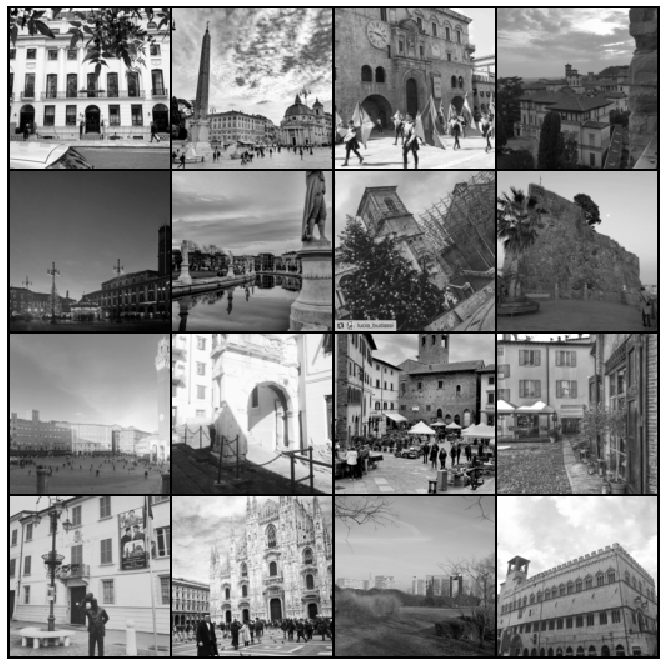

In [20]:
plt.figure(figsize=(12,12))
# plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(test['image_gray'], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

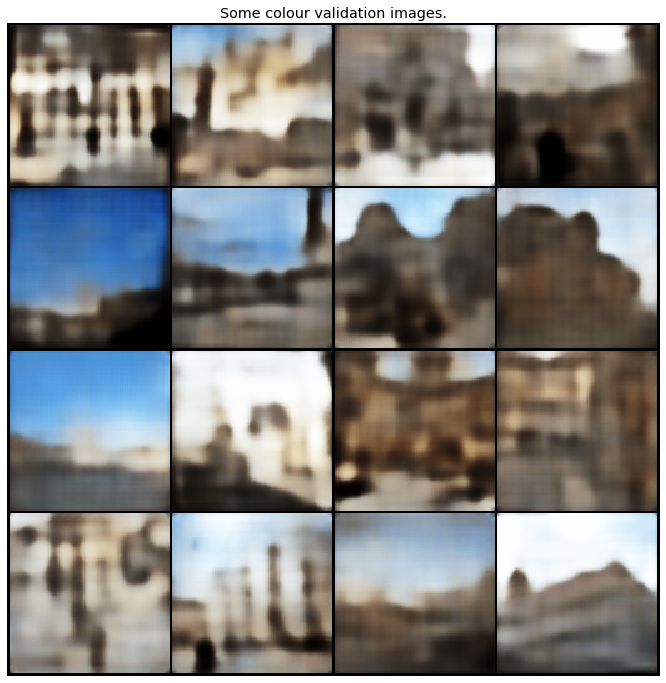

In [21]:
plt.figure(figsize=(12,12))
plt.title('Some colour validation images.', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(img_test, nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()